In [ ]:

from datasets import OpenmlDataset, OpenmlDatasetLoader
from datasets import dataset_train_test_split
from preencoder import PreEncoder 
from models import ToyModel          
from sklearn.metrics import mean_squared_error, accuracy_score
import random
import numpy as np

### example task_ids ###

# 361066 bank-marketing
# 361076 wine_quality
# 361085 sulfur
# 361088 superconduct
# 361089 california
# 361110 electricity
# 361111 eye_movements
# 361112 KDDCup09_upselling
# 361114 rl
# 361116 compass
# 361099 Bike_Sharing_Demand
# 361102 house_sales
# ,361076,361085,361088,361089,361110,361111,361112,361114,361116, 361099,361102


# Num encoding PLE ENCODING memory error for { 361088 (79 features); Aggregation: feature; force_independence: True;} 
# Probleme aussi quand il y'a des features categorielles pour PLE EMBEDDING

# issues with dataset 361112

""" Faire deja les experiments et recolter les résultats 
- Pour chaque dataset, pour chaque méthode de pre-encoding, pour chaque méthode de pre-encoding, pour chaque taille d'embedding,
- Faire une moyenne des résultats pour chaque dataset
- Faire une moyenne des résultats pour chaque méthode de pre-encoding
- Faire une moyenne des résultats pour chaque taille d'embedding

 """
#[361066,361076,361085,361088,361089,361110,361111,361112,361114,361116,361099,361102]
#class [361066,361110,361112,361116] 
#regr [361076, 361089, 361099, 361102]

ids = [361066,361110,361112,361116, 361076, 361089, 361099, 361102]

#aggregation_method = ["feature","sample"]
#["baseline","numEncoder_Encoding","feature2vec"]

method = ["feature2vec"]
random_seeds = [42, 123, 456, 789, 101112]
emb_size = [8,20,50,100,180,200]

relative_perf ={}
results = {}
std = {}

for task_id in ids :
    

    dataset_loader = OpenmlDatasetLoader()
    dataset = dataset_loader.load(task_id)
    dataset.print_info()

    results[dataset.name] = {}
    std[dataset.name] = {}

    for m in method : 

        performances = []

        for seed in random_seeds:

            random.seed(seed)
            np.random.seed(seed)
            
            dataset_train, dataset_test = dataset_train_test_split(dataset, frac=0.7,seed_value=seed)

            preencoder = PreEncoder(method=m)
            preencoder.fit(dataset_train)
            
            dataset_val, dataset_test = dataset_train_test_split(dataset_test, frac=2/3, seed_value=seed)

            aggregation = 'feature'

            force_independence = False
            
            """ if m == "feature2vec" :
                force_independence = False
            else:
                force_independence = True """


            X_train, y_train = preencoder.transform(dataset_train, aggregation=aggregation, force_independence=force_independence)
            X_val, y_val = preencoder.transform(dataset_val, aggregation=aggregation, force_independence=force_independence)
            X_test, y_test = preencoder.transform(dataset_test, aggregation=aggregation, force_independence=force_independence)


            #dataset_train.print_info()
            #dataset_val.print_info()
            #dataset_test.print_info()

            model = ToyModel(task = dataset.task, 
                            n_epochs = 50, 
                            network = aggregation, 
                            m_features = len(dataset.categorical_indicator), 
                            h_dim=256, 
                            early_stopping=False)

            model.fit(X_train, y_train, X_val, y_val)

            #prediction and evaluation
            y_pred = model.predict(X_test)

            #different evaluation metrics 
            if dataset.task == "classification":
                accuracy = accuracy_score(y_test, y_pred)
                performances.append(accuracy*100)
            else:
                rmse = mean_squared_error(y_test, y_pred, squared=False)
                performances.append(rmse)
        std[dataset.name][m] = round(np.std(performances),3)
        results[dataset.name][m] = round(np.mean(performances),3)


#Evaluation. For each tuned configuration, we run 15 experiments with different random seeds and report the average performance on the test set.

## Evaluate the impact on the embeddings size for PLE

In [100]:

from datasets import OpenmlDataset, OpenmlDatasetLoader
from datasets import dataset_train_test_split
from preencoder import PreEncoder 
from models import ToyModel          
from sklearn.metrics import mean_squared_error, accuracy_score
import random
import numpy as np

seed=42
random.seed(seed)
np.random.seed(seed)

### example task_ids ###

# 361066 bank-marketing
# 361076 wine_quality
# 361085 sulfur
# 361088 superconduct
# 361089 california
# 361110 electricity
# 361111 eye_movements
# 361112 KDDCup09_upselling
# 361114 rl
# 361116 compass
# 361099 Bike_Sharing_Demand
# 361102 house_sales
# ,361076,361085,361088,361089,361110,361111,361112,361114,361116, 361099,361102

#["baseline","numEncoder_Encoding","feature2vec"]


#class [361066,361110,361112,361116] 
#regr [361076, 361089, 361099, 361102]

ids = [361066,361110,361112,361116]

m = "feature2vec"
random_seeds = [42, 123, 456, 789, 101112]

emb_size = [8,16,24,32,64]
bins_size = [3,8,16,24]


results = {size: [] for size in emb_size}
std = {}

for e in emb_size :
    
    #std[dataset.name] = {}

    performances = []

    for task_id in ids:

        dataset_loader = OpenmlDatasetLoader()
        dataset = dataset_loader.load(task_id)
        dataset.print_info()
        
        dataset_train, dataset_test = dataset_train_test_split(dataset, frac=0.7,seed_value=seed)

        preencoder = PreEncoder(method=m)
        preencoder.fit(dataset_train,emb=e)
        
        dataset_val, dataset_test = dataset_train_test_split(dataset_test, frac=2/3, seed_value=seed)

        aggregation = 'sample'

        force_independence = True
        
        """ if m == "feature2vec" :
            force_independence = False
        else:
            force_independence = True """


        X_train, y_train = preencoder.transform(dataset_train, aggregation=aggregation, force_independence=force_independence)
        X_val, y_val = preencoder.transform(dataset_val, aggregation=aggregation, force_independence=force_independence)
        X_test, y_test = preencoder.transform(dataset_test, aggregation=aggregation, force_independence=force_independence)


        #dataset_train.print_info()
        #dataset_val.print_info()
        #dataset_test.print_info()

        model = ToyModel(task = dataset.task, 
                        n_epochs = 50, 
                        network = aggregation, 
                        m_features = len(dataset.categorical_indicator), 
                        h_dim=256, 
                        early_stopping=False)

        model.fit(X_train, y_train, X_val, y_val)

        #prediction and evaluation
        y_pred = model.predict(X_test)

        #different evaluation metrics 
        if dataset.task == "classification":
            accuracy = accuracy_score(y_test, y_pred)
            results[e].append(accuracy*100)
        else:
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            results[e].append(rmse)

-------------------------------
Dataset name: bank-marketing
n_samples: 10578
m_features: 7 (including 0 categorical features)
Task: classification
-------------------------------
Iter 0: Negative Sampling Loss = 53.3723
Iter 50: Negative Sampling Loss = 0.1159
Iter 100: Negative Sampling Loss = 0.0168
Iter 150: Negative Sampling Loss = 0.0106
Iter 200: Negative Sampling Loss = 0.0077
Iter 250: Negative Sampling Loss = 0.0053
Epoch :10 | Train loss: 0.511| Val loss: 0.525
Epoch :20 | Train loss: 0.507| Val loss: 0.525
Epoch :30 | Train loss: 0.503| Val loss: 0.530
Epoch :40 | Train loss: 0.502| Val loss: 0.533
Epoch :50 | Train loss: 0.502| Val loss: 0.537
-------------------------------
Dataset name: electricity
n_samples: 38474
m_features: 8 (including 1 categorical features)
Task: classification
-------------------------------
Iter 0: Negative Sampling Loss = 60.9970
Iter 50: Negative Sampling Loss = 1.5975
Iter 100: Negative Sampling Loss = 0.1278
Iter 150: Negative Sampling Loss =

In [101]:
average_performance = {size: np.mean(results[size]) for size in emb_size}
median_performance = {size: np.median(results[size]) for size in emb_size}

print("Average Performance:", average_performance)
print("Median Performance:", median_performance)

Average Performance: {8: 75.9038656139571, 16: 76.01527061349182, 24: 75.73110690094248, 32: 74.86207495424242, 64: 75.33565755962147}
Median Performance: {8: 76.46051855220284, 16: 76.56480775084842, 24: 76.36600059379076, 32: 74.32578442389143, 64: 75.91135606023593}


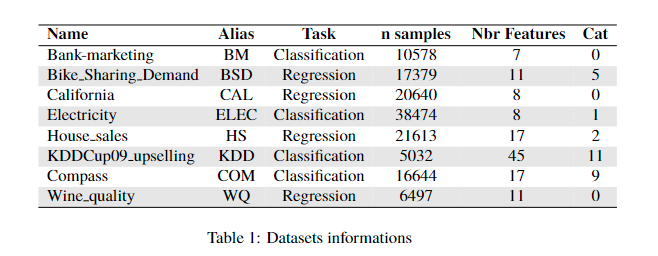

In [ ]:
import matplotlib.pyplot as plt

# Données
Average_Performance =  {8: 28.821978188575525, 16: 28.85770682314883, 24: 28.846661093396538, 32: 29.049459338609644, 64: 29.10688475649279}
Median_Performance =  {8: 0.5785798222307348, 16: 0.493047531861016, 24: 0.5161048866812021, 32: 0.49438561847223395, 64: 0.4932185975686406}

num_bins = {
    'bank-marketing': {3: 76.087, 8: 76.181, 16: 76.087, 24: 76.371},
    'wine_quality': {3: 0.71, 8: 0.726, 16: 0.725, 24: 0.72}
}

# Préparation des données pour le plot
bank_bins = list(num_bins['bank-marketing'].keys())
bank_accuracy = list(num_bins['bank-marketing'].values())

wine_bins = list(num_bins['wine_quality'].keys())
wine_rmse = list(num_bins['wine_quality'].values())

# Plot pour bank (accuracy)
plt.figure(figsize=(10, 5))
plt.plot(bank_bins, bank_accuracy, marker='o', linestyle='-', color='b')
plt.title('Accuracy as a function of the number of bins (bank-marketing)')
plt.xlabel('Number of bins')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

# Plot pour wine quality (rmse)
plt.figure(figsize=(10, 5))
plt.plot(wine_bins, wine_rmse, marker='o', linestyle='-', color='r')
plt.title('RMSE as a function of the number of bins (wine quality)')
plt.xlabel('Number of bins')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()